<h1><center><font size="25">Forecasting electricity demand with Python</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>April, 2021 (last update December 2021) </i></center>

+ [**Skforecast Docs**](https://joaquinamatrodrigo.github.io/skforecast/0.3/)

+ [**Time series forecasting with Python and Scikit-learn**](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn-0.3.html)

## Introduction
<br>

A [time series](https://en.wikipedia.org/wiki/Time_series) is a succession of chronologically ordered data spaced at equal or unequal intervals. The [forecasting](https://en.wikipedia.org/wiki/Forecasting#Time_series_methods) process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

This document shows an example of how to use forecasting methods to predict hourly electricity demand. For this purpose, [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/0.3/) is used, a simple Python library that allows, among other things, to adapt any **Scikit-learn** regressor to forecasting problems.

Same document using **Skforecast v0.4** [here](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html).
<br><br>

## Multi-Step Time Series Forecasting
<br>

The common objective of working with time series is not only to predict the next element in the series ($t_{+1}$) but an entire future interval or a point far away in time ($t_{+n}$). Each prediction jump is known as a step. There are several strategies that allow generating this type of multiple prediction:

**Recursive multi-step forecasting**
<br>

Since to predict the moment $t_{n}$ the value of $t_{n-1}$ is needed, which is unknown, it is necessary to make recursive predictions. New predictions use previous ones as predictors. This process is known as recursive forecasting or recursive multi-step forecasting.

<img src="./images/forecasting_multi-step-en.gif" style="width: 550px" alts="forecasting-python">

The main adaptation needed to apply [Scikit-learn](https://scikit-learn.org/stable/) models to recursive multi-step forecasting problems is to transform the time series into a matrix in which each value is associated with the time window (lags) preceding it.

<img src="./images/transform_timeseries.gif" style="width: 550px" alts="forecasting-python">

<center><font size='2.5'> <i>Transformation of a time series into a 5 lags matrix and a vector with the value of the series that follows each row of the matrix.</i></font></center>

This type of transformation also allows the inclusion of exogenous variables.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Transformación de una serie temporal junto con una variable exógena.</i></font></center>

**Direct multi-step forecasting**
<br>

The direct multi-step forecasting method consists of training a different model for each step. For example, to predict the following 5 values of a time series, 5 different models are required to be trained, one for each step. As a result, the predictions are independent of each other.

The main complexity of this approach is to generate the correct training matrices for each model. The `ForecasterAutoregMultiOutput` class in [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/0.3/) libraries automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires training multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformation of a time series into the necessary matrices to train a direct multi-step forecasting model.</i></font></center>
    
<br><br>

**Multiple output forecasting**
<br>

Certain models are capable of simultaneously predicting several values of a sequence (one-shot). An example of a model with this capability is the LSTM neural network.
<br><br>

## Use Case
<br>

A time series with electricity demand (MW) for the state of Victoria (Australia) from 2011-12-31 to 2014-12-31 is available. It is intended to generate a forecasting model capable of predicting the next day's energy demand at the hourly level.
<br>

## Libraries
<br>

The libraries used in this document are:

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In addition to the above, [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/0.3/), a library containing the classes and functions needed to adapt any **Scikit-learn** regression model to forecasting problems, is used. It can be installed in the following ways:

`pip install skforecast`

A specific version:

`pip install skforecast==0.3.0`

Last version (unstable):

`pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master`

In [2]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

## Data
<br>

The data used in this document were obtained from the **R** [tsibbledata]("https://tsibbledata.tidyverts.org/") package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

+ Time: date and time of the record.

+ Date: date of the record.

+ Demand: electricity demand (MW).

+ Temperature: temperature in Melbourne, capital of the state of Victoria.

+ Holiday: indicator if the day is a public holiday.

In [3]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data_raw = pd.read_csv(url, sep=',')
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


The *Time* column is stored as a `string`. To convert it to `datetime`, the function `pd.to_datetime()` is used. Once in `datetime` format, and to make use of **pandas** functionalities, it is set as an index. In addition, since the data has been recorded every 30 minutes, the frequency ('30min') is indicated.

In [4]:
# Data preparation
# ==============================================================================
data = data_raw.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


One of the first analyses to perform when working with time series is to verify whether the series is complete.

In [5]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [6]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [7]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

Although the data are at 30-minute intervals, the goal is to create a model capable of predicting hourly electricity demand, so the data must be aggregated. This type of transformation can be very fast, combining the Pandas time type index and its `resample()` method.

It is very important to use the `closed='left'` and `label='right'` arguments correctly in order not to introduce future information into the training, [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)). Suppose that values are available for 10:10, 10:30, 10:45, 11:00, 11:12 and 11:30. If the hourly average is to be obtained, the value assigned to 11:00 must be calculated using the values of 10:10, 10:30, and 10:45; and that of 12:00, with the value of 11:00, 11:12, and 11:30.

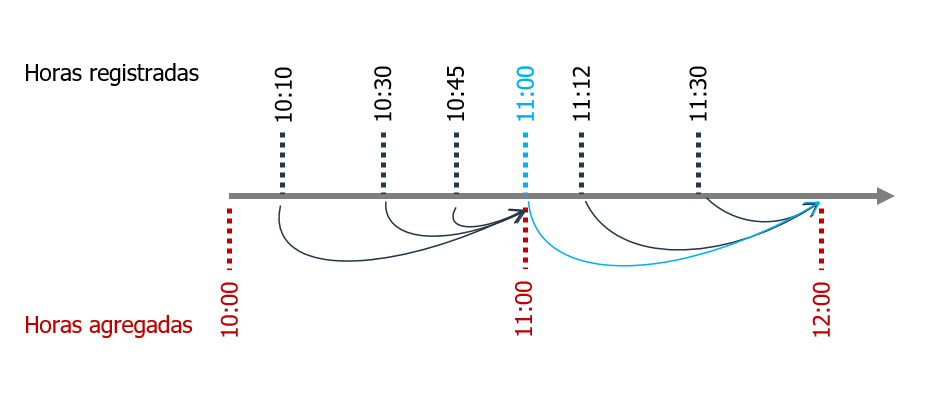

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "images/diagrama_resampling_datetime.PNG", width=600)

<center><font size='2.5'> <i>Diagram of temporal data aggregation without including forward-looking information.</i></font></center>

For the 11:00 average value, the 11:00 point value is not included because, in reality, the value is not yet available at that exact time.

In [9]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


The dataset starts on *2011-12-31 14:00:00* and ends on *2014-12-31 13:00:00*. The first 10 and the last 13 records are discarded so that it starts on *2012-01-01 00:00:00* and ends on *2014-12-30 23:00:00*. In addition, to optimize the hyperparameters of the model and evaluate its predictive capability, the data are divided into 3 sets, training, validation, and test.

In [10]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00


## Graphic exploration
<br>

When it is necessary to generate a forecasting model, plotting the time series values could be useful. This allows identifying patterns such as trends and seasonality.

**Full time series**

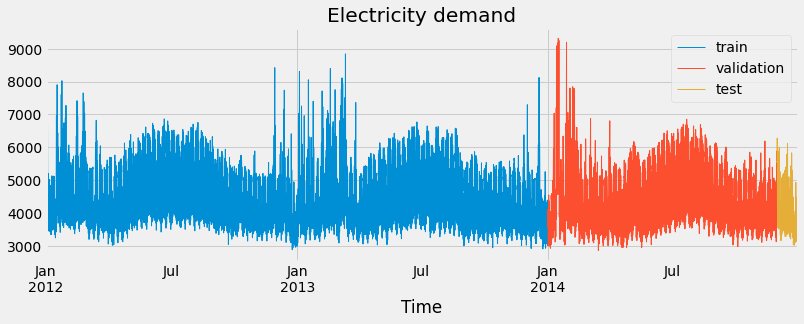

In [11]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

The above graph shows that electricity demand has annual seasonality. There is an increase centered on July and very accentuated demand peaks between January and March.
<br><br>

**Section of the time series**

Due to the variance of the time series, it is not possible to appreciate with a single chart the possible intraday pattern.

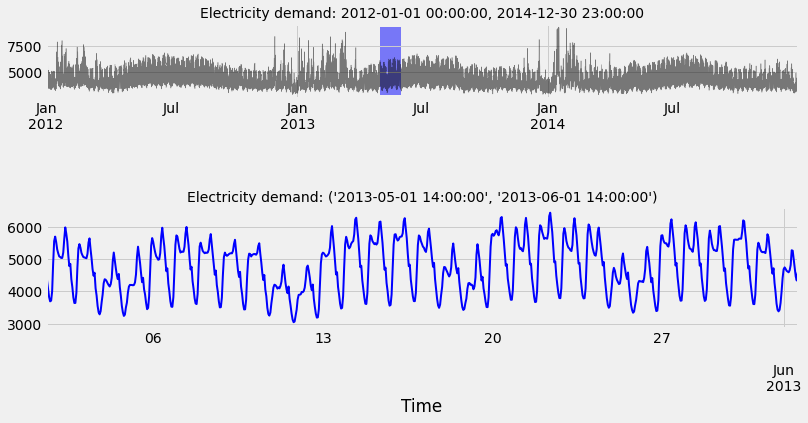

In [12]:
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Demand)
max_y = max(data.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

When zooming in on the time series, a clear weekly seasonality is evident, with higher consumption during the work week (Monday to Friday) and lower consumption on weekends. It is also observed that there is a clear correlation between the consumption of one day and that of the previous day.
<br><br>

**Annual, weekly and daily seasonality**

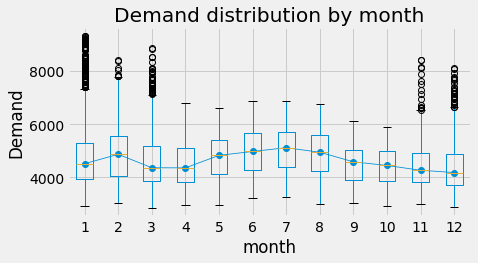

In [13]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');

It is observed that there is an annual seasonality, with higher (median) demand values in June, July, and August, and with high demand peaks in November, December, January, February, and March.

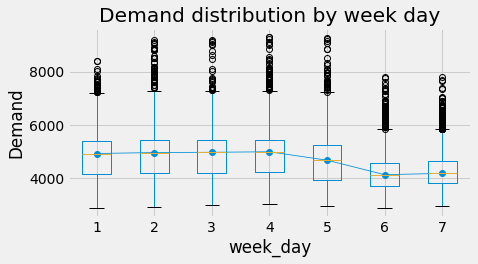

In [14]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

Weekly seasonality shows lower demand values during the weekend.
<br><br>

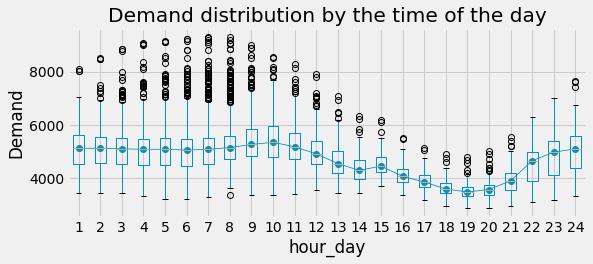

In [15]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');

There is also a daily seasonality, with demand decreasing between 16:00 and 21:00 hours.
<br><br>

**Holidays and non-holiday days**

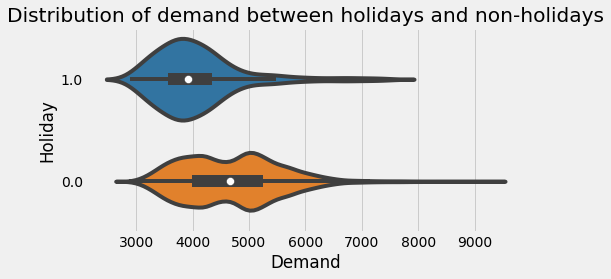

In [16]:
# Violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = data.assign(Holiday = data.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday');

Holidays tend to have lower consumption.
<br><br>

**Autocorrelation plots**

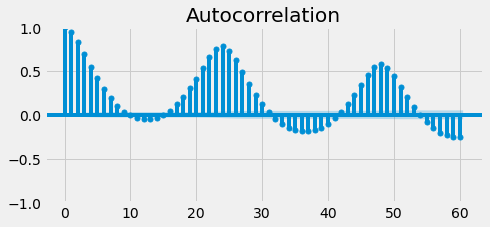

In [17]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

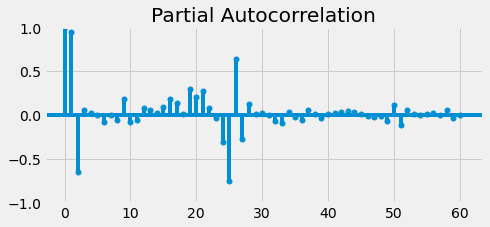

In [18]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()

The autocorrelation and partial autocorrelation plots show a clear association between one hour's demand and previous hours, as well as between one hour's demand and the same hour's demand on previous days. This type of correlation is an indication that autoregressive models can work well.
<br><br>

## Recursive autoregressive forecasting
<br>

A recursive autoregressive model (`ForecasterAutoreg`) is created and trained from a linear regression model with a Ridge penalty and a time window of 24 lags. The latter means that, for each prediction, the demand values of the previous 24 hours are used as predictors.

### Forecaster training

In [19]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(normalize=True),
                lags      = 24
             )

forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Exogenous variable: False, None
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

### Backtest
<br>

How the model would have behaved if it had been trained with the data from 2012-01-01 00:00 to 2014-11-30 23:59 and then, at 23:59 each day, the following 24 hours were predicted is evaluated. This type of evaluation, known as [Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html), can be easily implemented with the function `backtesting_forecaster()`. This function returns, in addition to the predictions, an error metric.

In [20]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.Demand,
                            initial_train_size = len(data.loc[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data[end_validation:].index)

Number of observations used for training: 25560
Number of observations used for testing: 720
    Number of folds: 30
    Number of steps per fold: 24


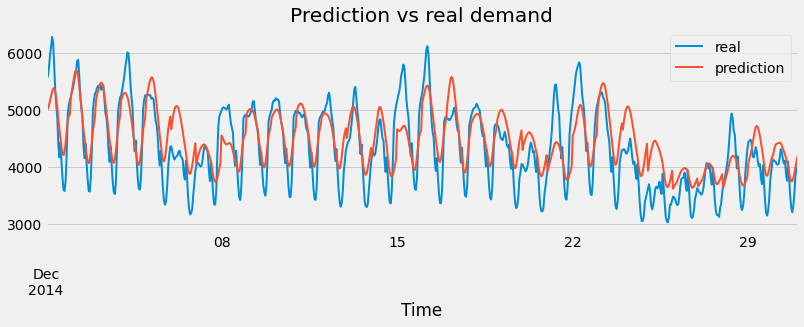

In [21]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'Demand'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [22]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: [363.06587567]


### Hyperparameter tuning
<br>

In the trained `ForecasterAutoreg` object, the first 24 lags and a [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model with the default hyperparameters have been used. However, there is no reason why these values are the most appropriate.

To identify the best combination of lags and hyperparameters, a Grid Search with validation by [Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html) is used. This process consists of training a model with diferent combinations of hyperparameters and lags and evaluating its predictive capacity by [Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html). In the search process, it is important to evaluate the models using only the validation data and not to include the test data, which are used only to evaluate the final model.

In [23]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags      = 24 # This value will be replaced in the grid search
              )

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_validation, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        method      = 'backtesting',
                        initial_train_size = len(data[:end_train]),
                        return_best = True,
                        verbose     = False
                  )

2021-12-17 12:40:54,655 root       INFO  Number of models compared: 30
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.44s/it]
2021-12-17 12:41:17,010 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 23 24 25 47 48 49] 
params: {'alpha': 0.004641588833612777}



In [24]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,alpha
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.004641588833612777},269.698640,0.004642
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.021544346900318832},271.108777,0.021544
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},296.636751,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},330.635873,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},344.364905,0.004642
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.1},359.323464,0.100000
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318832},372.113405,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},396.836961,0.100000
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},411.305373,0.464159
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},428.373252,0.464159


The best results are obtained by using the lags [1, 2, 3, 23, 24, 25, 47, 48, 49] and a [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) configuration {'alpha': 0.004642}. By specifying `return_best = True` in the `grid_search_forecaster()` function, at the end of the process, the forecaster object is automatically retrained with the best configuration found and the complete dataset (train + validation).

In [25]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(alpha=0.004641588833612777, normalize=True)
Lags: [ 1  2  3 23 24 25 47 48 49]
Exogenous variable: False, None
Parameters: {'alpha': 0.004641588833612777, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

### Backtest with test data
<br>

Once the best model has been identified and trained, its error in predicting the test data is calculated.

Number of observations used for training: 25560
Number of observations used for testing: 720
    Number of folds: 30
    Number of steps per fold: 24


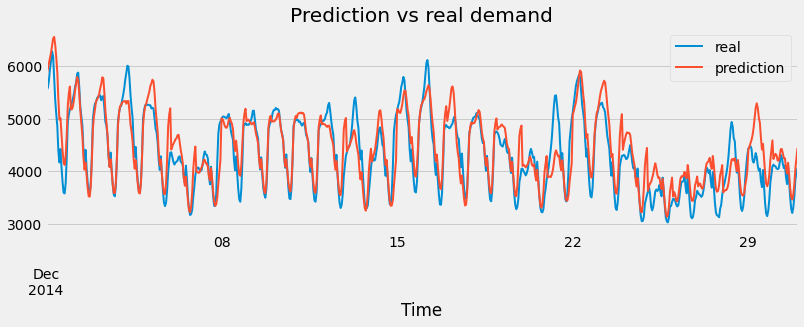

In [26]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.Demand,
                            initial_train_size = len(data[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Datetime index added
predictions = pd.Series(data=predictions, index=data[end_validation:].index)

fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [27]:
# Error backtest
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: [260.86993041]


After optimization of lags and hyperparameters, the prediction error has been reduced from 363 to 261.
<br><br>

### Prediction intervals
<br>

A prediction interval defines the interval within which the true value of "y" can be expected to be found with a given probability.

Rob J Hyndman and George Athanasopoulos, in their book *Forecasting: Principles and Practice*, list [multiple ways to estimate prediction intervals](https://otexts.com/fpp2/prediction-intervals.html), most of which require that the residuals (errors) of the model are normally distributed. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/0.3/) library for the `ForecasterAutoreg` and `ForecasterAutoregCustom` type models.
<br><br>

In [28]:
# Backtest with test data and prediction intervals
# ==============================================================================
metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = data.Demand,
                            initial_train_size = len(data.Demand[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print('Backtesting metric:', metric)

# Datetime index added
predictions = pd.DataFrame(data=predictions, index=data[end_validation:].index)

Number of observations used for training: 25560
Number of observations used for testing: 720
    Number of folds: 30
    Number of steps per fold: 24
Backtesting metric: [260.86993041]


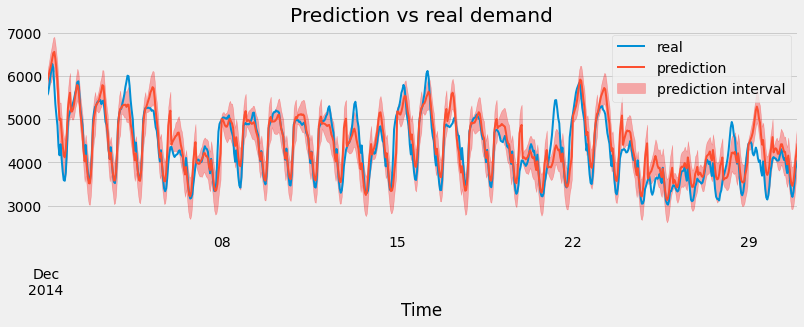

In [29]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.3,
    color = 'red',
    label = 'prediction interval' 
)
ax.legend();

In [30]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[end_validation:, 'Demand'] >= predictions.iloc[:, 1]) & \
                     (data.loc[end_validation:, 'Demand'] <= predictions.iloc[:, 2]),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {100 * coverage}")

Predicted interval coverage: 78.47222222222221


The predicted interval has a lower coverage than expected (80%). It may be due to the marked high error made by the model for days 21, 24, and 25. These days are within the Christmas holiday period, usually characterized by a different consumption behavior than the rest of the month.

### Anticipated daily forecast
<br>

Until now, the model was evaluated assuming that the next day's predictions are run right at the end of the previous day. In practice, this is not very useful as there is no time to manage the first hours of the next day.

Suppose now that the predictions for the following day have to be generated at 11:00 a.m. each day to have sufficient leeway. That is, at 11:00 a.m. on day $D$ one has to predict the hours [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] of that same day, and the hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] of day $D+1$. This implies that a total of 36 hours into the future have to be predicted, although just the las 24 needs to be stored.

The backtesting process adapted to this scenario is performed on a day-to-day basis and consists of the following steps. 

*Note: The Forecaster is already trained with train and validation dataset (`data.loc[:end_validation]`).*

1. At 11:00 a.m. on the first day of the test set, the next 36 hours (the remaining 12 hours of the day plus 24 hours of the following day) are predicted.

2. Only the next day's predictions are stored, that is from position 12 onwards.

3. The next day until 11:00 a.m. is added to the test set.

4. The process is repeated.

Thus, at 11:00 a.m. each day, the model has access to the actual demand values recorded up to that time.

This process can be easily performed with the `predict()` method of a `ForecasterAutoreg` object. If nothing is specified, the prediction starts after the last training value, but, if the `last_window` argument is specified, it uses these values as a starting point.

In [31]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predicciones of day D+1.


    Returns 
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window.to_numpy()
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)
    
    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predicciones

In [32]:
# Backtest
# ==============================================================================
predictions = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = data.loc[end_validation:, 'Demand'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



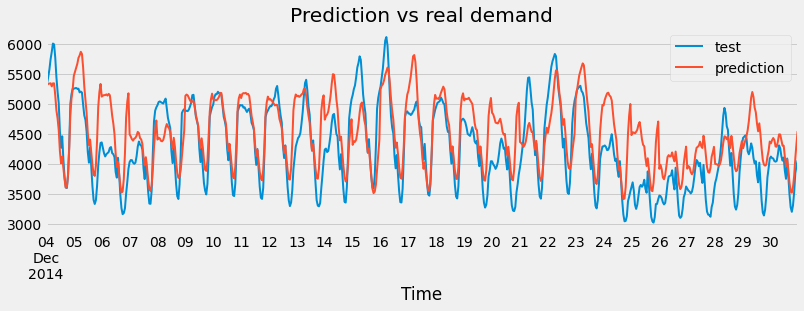

In [33]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
# data_train.plot(ax=ax, label='train')
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [34]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )
print(f"Backtest error: {error}")

Backtest error: 402.8286062113978


As expected, as the forecast horizon increases from 24 to 36 hours, so does the error.

### Predictors importance
<br>

Since the `ForecasterAutoreg` object uses **Scikit-learn** models, once trained, the importance of predictors can be accessed. When the regressor used is a `LinearRegression()`, `Lasso()` or `Ridge()`, the coefficients of the model reflect their importance, obtained with the `get_coef()` method. In `GradientBoostingRegressor()` or `RandomForestRegressor()` regressors, the importance of predictors is based on impurity reduction and is accessible through the `get_feature_importances()` method. In both cases, the values returned are sorted as the lags order.

In [35]:
# Predictors importance
# ==============================================================================
importance = forecaster.get_coef()
dict(zip(forecaster.lags, importance))

{1: 1.0810099635064905,
 2: -0.08775876436019982,
 3: -0.044163330328981974,
 23: 0.13160723492833393,
 24: 0.403214555002129,
 25: -0.52000591098844,
 47: -0.08188683373397783,
 48: 0.30167049119629885,
 49: -0.21091820466992908}

<br>

## Forecasting with exogenous variables
<br>

In the previous example, only lags of the predicted variable itself have been used as predictors. In some scenarios, it is possible to have information about other variables, **whose future value is known**, and which can serve as additional predictors in the model. Typical examples are:

+ Holidays (local, national...)

+ Month of the year

+ Day of the week

+ Time of day

In this use case, the graphical analysis showed evidence that, on public holidays, demand is lower. Whether a day is a holiday or not can be known in the future, so it can be used as an exogenous variable. See how it affects the model if the Holiday variable available in the dataset is included as a predictor.

### Forecaster Training
<br>

The hyperparameters and lags identified as optimal in the previous section are used.

In [36]:
# The Holiday column is converted from boolean to integer
data.loc[:,'Holiday'] = data['Holiday'].astype(int)
data_train.loc[:,'Holiday'] = data_train['Holiday'].astype(int)
data_test.loc[:,'Holiday'] = data_test['Holiday'].astype(int)

In [37]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(alpha=0.00464, normalize=True),
                lags      = [1, 2, 3, 23, 24, 25, 47, 48, 49],
             )

forecaster.fit(y=data.Demand[:end_validation], exog=data.Holiday[:end_validation])
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(alpha=0.00464, normalize=True)
Lags: [ 1  2  3 23 24 25 47 48 49]
Exogenous variable: True, <class 'pandas.core.series.Series'>
Parameters: {'alpha': 0.00464, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

### Anticipated daily forecast
<br>

The backtesting process including as a predictor whether the day is a holiday or not is repeated.

In [38]:
# Backtest
# ==============================================================================
predictions = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = data.loc[end_validation:, 'Demand'],
                    exog       = data.loc[end_validation:, 'Holiday'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



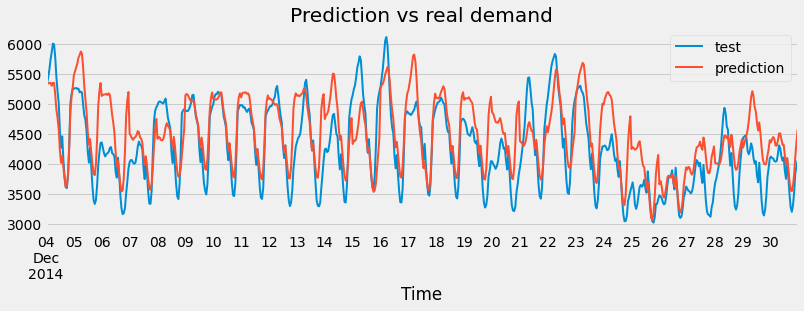

In [39]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
# data_train.plot(ax=ax, label='train')
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [40]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )
print(f"Backtest error: {error}")

Backtest error: 381.5161730746221


By using as an exogenous variable whether the day is a holiday or not, the prediction error is slightly reduced from 403 to 382. See what happens when adding as predictors whether the previous and next day are holidays, the day of the week, and the time of day.

In [41]:
# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
data.loc[:,'Holiday_day_before'] = data['Holiday'].shift(24)
data.loc[:,'Holiday_next_day']   = data['Holiday'].shift(-24)
data=data.dropna()

# One hot encoding of week_day and hour_day
data=pd.get_dummies(data, columns=['week_day', 'hour_day'])
data.head(3)

,Demand,Temperature,Holiday,month,Holiday_day_before,Holiday_next_day,week_day_1,week_day_2,week_day_3,week_day_4,...,hour_day_15,hour_day_16,hour_day_17,hour_day_18,hour_day_19,hour_day_20,hour_day_21,hour_day_22,hour_day_23,hour_day_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,5262.895338,32.825,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 01:00:00,5786.043417,34.500,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 02:00:00,6236.144167,36.725,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(alpha=0.00464, normalize=True),
                lags      = [1, 2, 3, 23, 24, 25, 47, 48, 49],
             )

exog = [column for column in data.columns if column.startswith(('week_day', 'hour', 'Holiday'))]
forecaster.fit(y=data.Demand[: end_validation], exog=data[exog][: end_validation])

# Backtest
# ==============================================================================
predictions = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = data.loc[end_validation:, 'Demand'],
                    exog       = data.loc[end_validation:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
                )

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )
print(f"Backtest error: {error}")

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29']

Backtest error: 323.7230435311855


The new predictors further reduce the model error.

### Include temperature as a predictor
<br>

Since temperature is also available in the data set and is related to demand, it might be tempting to incorporate it as a predictor. However, this approach **would not be correct** since the future temperature is unknown. It is possible to use the temperature forecast as a predictor for the model, but in that case, the model would have to be trained on the forecast temperature, not the actual one.
<br><br>

## Direct multi-step forecasting
<br>

The `ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. This type of models can be obtained with the `ForecasterAutoregMultiOutput` class and can include one or multiple exogenous variables.
<br><br>

### Forecaster train and tuning
<br>

Unlike when using `ForecasterAutoreg` or `ForecasterAutoregCustom`, the number of steps to be predicted must be indicated in the `ForecasterAutoregMultiOutput` type models.

In [43]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = XGBRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # This value will be replaced in the grid search
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500]}

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_validation, 'Demand'],
                        exog        = data.loc[:end_validation, exog],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_absolute_error',
                        method      = 'backtesting',
                        initial_train_size = len(data.loc[:end_train]),
                        return_best = True,
                        verbose     = False
                  )

2021-12-17 12:42:05,138 root       INFO  Number of models compared: 2
loop param_grid:   0%|                                                                           | 0/2 [00:00<?, ?it/s]2021-12-17 12:43:15,926 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 24 observations are excluded.

loop param_grid:  50%|█████████████████████████████████                                 | 1/2 [01:52<01:52, 112.32s/it]2021-12-17 12:49:35,407 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 24 observations are excluded.

loop lags_grid: 100%|███████████████████████████████████████████████████████████████████| 1/1 [08:14<00:00, 494.15s/it]
2021-12-17 12:50:19,377 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 23 24] 
params: {'n_estimators': 500}



In [44]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,n_estimators
1,"[1, 2, 3, 23, 24]",{'n_estimators': 500},242.334326,500
0,"[1, 2, 3, 23, 24]",{'n_estimators': 100},257.039336,100


### Anticipated daily forecast
<br>

The backtesting process, including the new exogenous variables, is repeated.

In [45]:
# Backtest
# ==============================================================================
predictions = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = data.loc[end_validation:, 'Demand'],
                    exog       = data.loc[end_validation:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
                )

Backtesting starts at day: 2014-12-02 11:00:00
Days predicted in the backtesting: ['2014-12-03' '2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07'
 '2014-12-08' '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12'
 '2014-12-13' '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17'
 '2014-12-18' '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22'
 '2014-12-23' '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27'
 '2014-12-28' '2014-12-29']



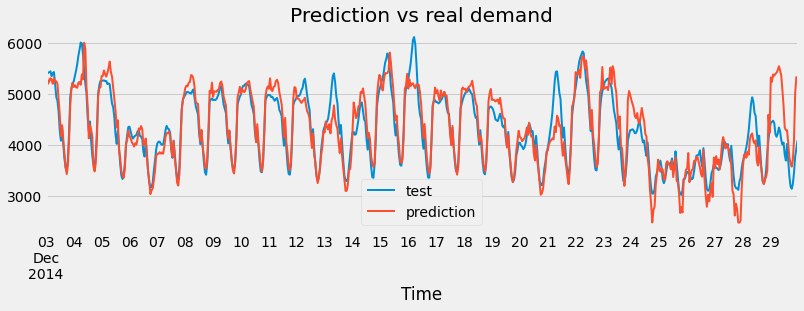

In [46]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [47]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )
print(f"Backtest error: {error}")

Backtest error: 232.0077044501592


In this case, using an XGBRegressor model and the direct multi-step strategy generates better results than the recursive strategy with a linear model.

## Session info

In [48]:
import session_info
session_info.show(html=False)

-----
ipykernel           6.5.1
matplotlib          3.5.0
numpy               1.21.4
pandas              1.3.4
seaborn             0.11.2
session_info        1.0.0
skforecast          0.3.0
sklearn             1.0.1
statsmodels         0.13.1
xgboost             1.5.1
-----
IPython             7.29.0
jupyter_client      7.1.0
jupyter_core        4.9.1
-----
Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
-----
Session information updated at 2021-12-17 12:58


## Bibliography
<br>

[**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/0.3/)

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [book](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [book](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [book](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [book](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

In [49]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    #font-size: 16px;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    #font-size: 1em;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting electricity demand with Pythonn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py29-forecasting-demanda-energia-electrica-python.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.